### Table of Contents ###
1. [Fetch Data](#Fetch-Data)
2. [Test/Train Split](#Test/Train-Split)
3. [Functions](#Functions)
4. [Modeling](#Modeling)
    * [Simple Linear SVC](#Simple-Linear-SVC)
    * [Dimensionality Reduction using PCA](#Dimensionality-Reduction)
    * [PCA + RandomForest](#PCA-+-RandomForest)
    * [PCA + Logistic Regression](#PCA-+-Logistic-Regression)
    * [PCA + XGBoost](#PCA-+-XGBoost)
    * [PCA + PolySVC](#PCA-+-PolySVC)
    * [Try Other Dimensionality Reduction Methods](#Other-Dimensionality-Reduction-Methods)
5. [Final Model](#Final-Model)
6. [Save Model](#Save-Model)

### Fetch Data ###

In [18]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='data/')

Import Libraries

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [20]:
mnist.data.shape

(70000, 784)

### Test/Train Split ###

MNIST dataset contains 70,000 images of handwritten digits. I have created a smaller training set below for initial exploration, so that I could train various models quickly. Smaller training set has a size of 5000 images. Once an appropriate machine learning algorithm has been narrowed down, I will use the larger training set to hopefully improve the model. 30% of data has been reserved as test dataset.

Stratified sampling was used to ensure there is no class imbalance for both in cases of smaller and larger test/train datasets.


In [21]:
X = mnist.data
y = mnist.target

#using a small training set so that models don't take long to run (initial use)
X_train, X_test_large, y_train, y_test_large = train_test_split(X, y, train_size = 5000, random_state = 4444, stratify= y)

X_train_Large, X_test_Large, y_train_Large, y_test_Large = train_test_split(X, y, test_size = .3, random_state = 4444, stratify= y)


#reduced sample
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .3, random_state = 4444, stratify= y_train)

### Functions ###

In [36]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plotConfusionMatrix(y_true, 
                        y_pred, 
                        ax=None, 
                        title=''):
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches(8,6)
        ax = fig.add_subplot(111)
    
    ax = sns.heatmap(confusion_matrix(y_true,y_pred), ax=ax)

    ax.set_title(title + ' Confusion Matrix')
    ax.set_ylabel('True digits')
    ax.set_xlabel('Predicted digits')
    

def plot_roc_curves(X_train,
                    y_train,
                    X_test,
                    y_test, 
                    classifier):
    
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    n_classes = y_train_bin.shape[1]


    # Learn to predict each class against the other
    classifier_OneVsRest = OneVsRestClassifier(classifier)
    
    y_score = None
    
    try:
        y_score = classifier_OneVsRest.fit(X_train, y_train_bin).decision_function(X_test)
    except AttributeError:
        y_score = classifier_OneVsRest.fit(X_train, y_train_bin).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC multi-class')
    ax.legend(loc="best")
    fig.set_size_inches(12,8)
    plt.show()
    

''' 
    This method fits the provided pipeline on the training set. Then performs predictions on the
    training set followed by the test set. Then it calculates the following metrics on these predictions:
    * Prediction accuracy on the training set
    * Prediction accuraty on the test set
    * Produces a classification report on the training set and the test set (which includes precision, recall, 
        f1 score for each class)
    * Plots confusions matrices for training and test set predictions
    * Plots ROC curves for each class on a single single graph
'''
def runPipeline(pipeLine, X_train, y_train, X_test, y_test):
    %%timeit -n1 -r1
    pipeLine.fit(X_train,y_train)

    y_train_pred = pipeLine.predict(X_train)
    y_test_pred = pipeLine.predict(X_test)
    
    print('train set accuracy: ', accuracy_score(y_train, y_train_pred))
    print('test set accuracy: ', accuracy_score(y_test, y_test_pred))
    print('')
    print('Classification Report: Train set')
    print(classification_report(y_train, y_train_pred))
    print('')
    print('Classification Report: Test set')
    print(classification_report(y_test, y_test_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(18,6)
    plotConfusionMatrix(y_train, y_train_pred, ax1, title='Train')
    plotConfusionMatrix(y_test, y_test_pred, ax2, title='Test')

    plot_roc_curves(X_train, y_train,X_test, y_test, pipeLine)
    
    return(y_train_pred, y_test_pred)

### Modeling ###

In this section I will try out a few different machine learning algorithm to find out how they will perform

#### Simple Linear SVC ####

Linear SVC lacks accuracy. This makes sense, digit recognition seems to be a non-linear problem.

train set accuracy:  0.996285714286
test set accuracy:  0.824030769231

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       345
        1.0       1.00      1.00      1.00       394
        2.0       1.00      1.00      1.00       349
        3.0       0.99      1.00      1.00       357
        4.0       1.00      1.00      1.00       341
        5.0       0.99      1.00      1.00       316
        6.0       1.00      1.00      1.00       344
        7.0       1.00      1.00      1.00       365
        8.0       1.00      0.97      0.98       341
        9.0       0.99      1.00      0.99       348

avg / total       1.00      1.00      1.00      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.91      0.91      0.91      6410
        1.0       0.92      0.94      0.93      7314
        2.0       0.84      0.80      0.82      6491
        3.

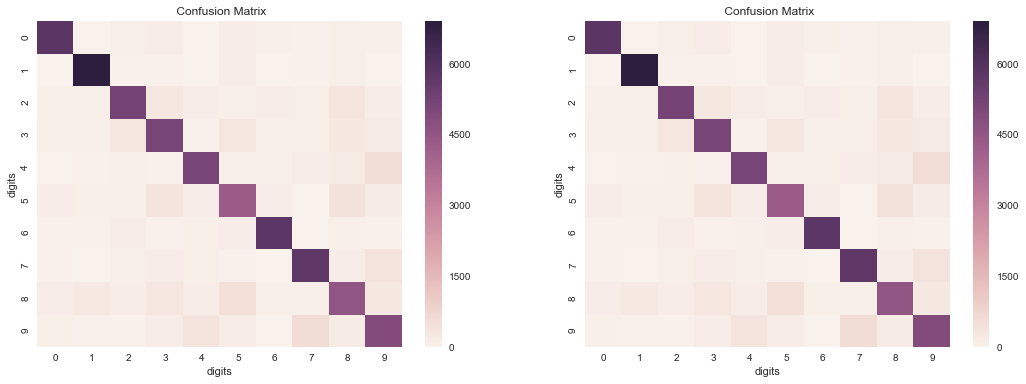

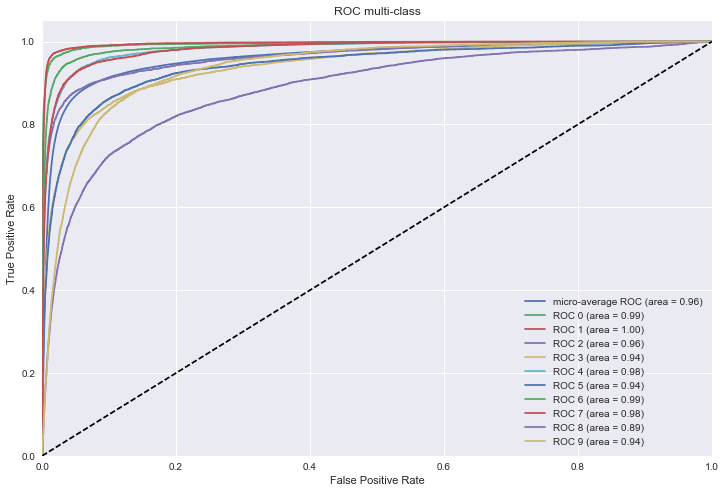

In [17]:
simpleLinearPipeLine = Pipeline([
                            ('classifier', svm.LinearSVC(random_state=42))
                         ])

simpleLinearPipeLine_y_train_pred, simpleLinearPipeLine_y_test_pred = runPipeline(simpleLinearPipeLine, 
                                                                                  X_train, y_train, 
                                                                                  X_test_large, y_test_large)

### Dimensionality Reduction ###

I will employ Principal Component Analysis (PCA) to reduce the number of features being used as inputs in the model (in other words, to perform feature selection). Dimentionality reduction should improve speed and memory required to train the model. Also, PCA eliminates multicolinearity that existed between original inputs, which should improve the performance of the model. 

It is tricky to figure out how many components of PCA to use in the model. I'm using a grid search in which I will be changing the number of PCA component from 5 to 30 with increments of 5 to figure out the number of components that yields the best model.

In [23]:
randomForest = RandomForestClassifier()

pca = PCA()
pca_n_components = range(5,30,5)

pipe = Pipeline([
    ('reduce_dim', pca),
    ('classify', randomForest)
])

param_grid = [
    {
        'reduce_dim__n_components': pca_n_components 
    }]

gridSearchEst = GridSearchCV(pipe, cv=3, n_jobs=6, param_grid=param_grid)

gridSearchEst.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=Non...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=6,
       param_grid=[{'reduce_dim__n_components': range(5, 30, 5)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

It looks like 25 PCA components performed the best.

In [24]:
gridSearchEst.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

After manually trying the pipeline for numbers around 25... 26 components seem to be the winning number

OK!!! let's try a whole bunch of models ...

#### PCA + RandomForest ####
[Back to Table of Contents](#Table-of-Contents)

With random forests, larger training set did better than the smaller one. Quite fast to train.

train set accuracy:  0.951163265306
test set accuracy:  0.915619047619

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97      4832
        1.0       0.98      0.98      0.98      5514
        2.0       0.95      0.94      0.95      4893
        3.0       0.94      0.93      0.93      4999
        4.0       0.95      0.95      0.95      4777
        5.0       0.94      0.95      0.94      4419
        6.0       0.96      0.97      0.97      4813
        7.0       0.95      0.96      0.96      5105
        8.0       0.94      0.93      0.93      4777
        9.0       0.93      0.92      0.93      4871

avg / total       0.95      0.95      0.95     49000


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.95      0.96      0.96      2071
        1.0       0.97      0.98      0.97      2363
        2.0       0.91      0.91      0.91      2097
        3.

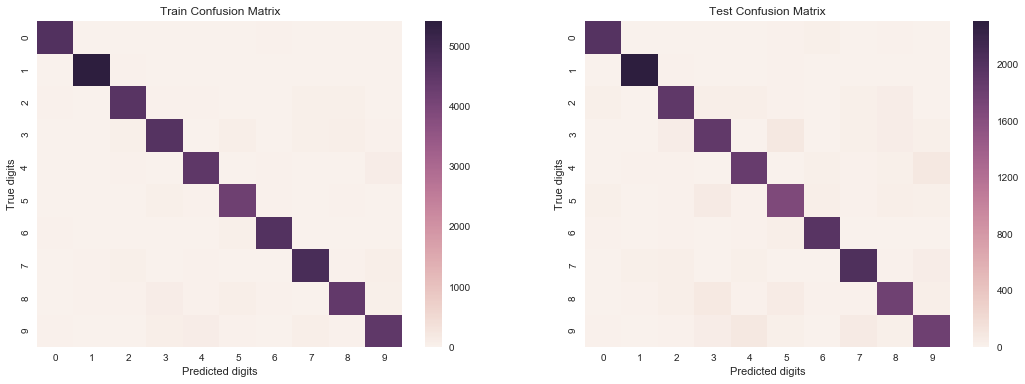

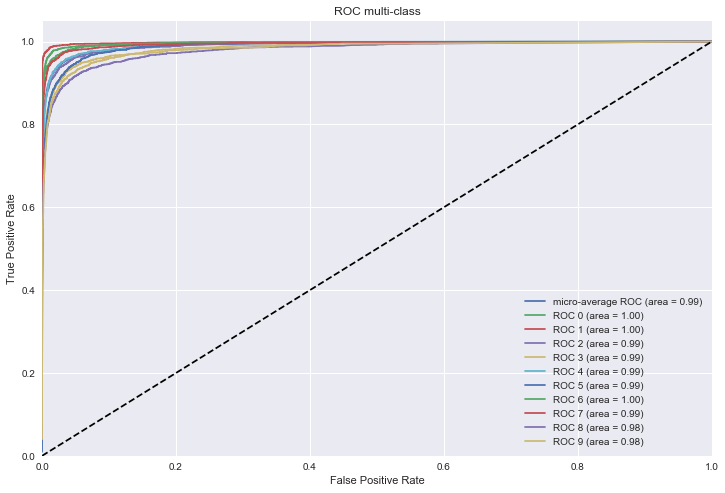

1 loop, best of 1: 1min 54s per loop


In [37]:
%%timeit -n1 -r1

pca_ranForest = Pipeline([('dim_reduction',PCA(n_components=26)),
                    ('classifier', RandomForestClassifier(min_samples_leaf=10))])


pca_ranForest_y_train_pred, pca_ranForest_y_test_pred = runPipeline(pca_ranForest, 
                                                                                  X_train_Large, y_train_Large, 
                                                                                  X_test_Large, y_test_Large)

#### PCA + Logistic Regression ####
[Back to Table of Contents](#Table-of-Contents)

Accuracy is not great compared to other algorithms

train set accuracy:  0.857224489796
test set accuracy:  0.857238095238

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       0.94      0.91      0.93      4832
        1.0       0.93      0.94      0.93      5514
        2.0       0.85      0.82      0.84      4893
        3.0       0.83      0.80      0.82      4999
        4.0       0.85      0.86      0.86      4777
        5.0       0.71      0.84      0.77      4419
        6.0       0.89      0.89      0.89      4813
        7.0       0.91      0.87      0.89      5105
        8.0       0.83      0.81      0.82      4777
        9.0       0.82      0.81      0.82      4871

avg / total       0.86      0.86      0.86     49000


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.94      0.92      0.93      2071
        1.0       0.94      0.94      0.94      2363
        2.0       0.86      0.83      0.84      2097
        3.

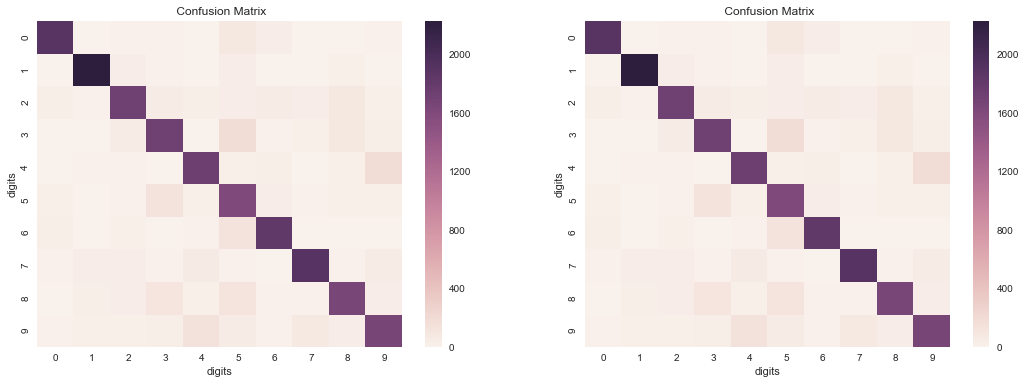

In [10]:
%%timeit -n1 -r1

pca_naiveBayes = Pipeline([('dim_reduction',PCA(n_components=26)),
                    ('classifier', GaussianNB())])


pca_naiveBayes_y_train_pred, pca_naiveBayes_y_test_pred = runPipeline(pca_naiveBayes, 
                                                                                  X_train_Large, y_train_Large, 
                                                                                  X_test_Large, y_test_Large)

#### PCA + XGBoost ####
[Back to Table of Contents](#Table-of-Contents)

train set accuracy:  0.998857142857
test set accuracy:  0.887184615385

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       345
        1.0       1.00      1.00      1.00       394
        2.0       1.00      1.00      1.00       349
        3.0       1.00      0.99      1.00       357
        4.0       1.00      1.00      1.00       341
        5.0       1.00      1.00      1.00       316
        6.0       1.00      1.00      1.00       344
        7.0       0.99      1.00      1.00       365
        8.0       1.00      1.00      1.00       341
        9.0       1.00      1.00      1.00       348

avg / total       1.00      1.00      1.00      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.95      0.92      0.94      6410
        1.0       0.96      0.97      0.96      7314
        2.0       0.88      0.87      0.87      6491
        3.

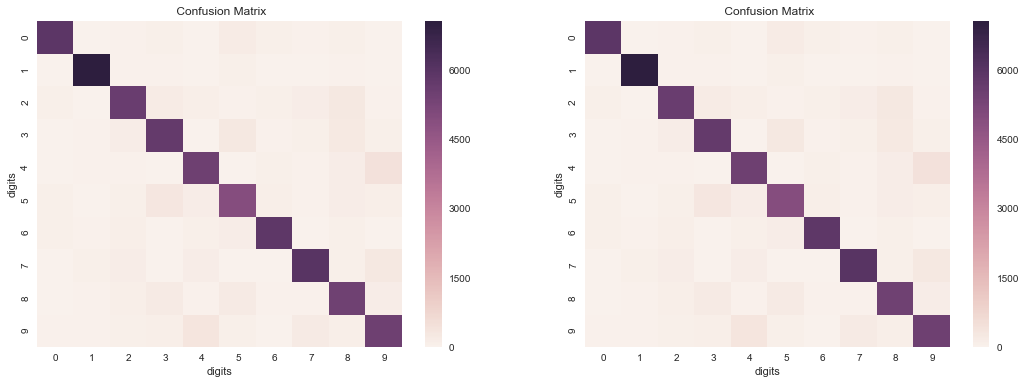

In [13]:
%%timeit -n1 -r1

pca_gradientboost = Pipeline([('dim_reduction',PCA(n_components=26)),
                    ('classifier', GradientBoostingClassifier(min_samples_leaf=10))])


pca_gradientboost_y_train_pred, pca_gradientboost_y_test_pred = runPipeline(pca_gradientboost, 
                                                                                  X_train, y_train, 
                                                                                  X_test_large, y_test_large)

#### PCA + PolySVC ####
[Back to Table of Contents](#Table-of-Contents)

train set accuracy:  1.0
test set accuracy:  0.946476923077

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       345
        1.0       1.00      1.00      1.00       394
        2.0       1.00      1.00      1.00       349
        3.0       1.00      1.00      1.00       357
        4.0       1.00      1.00      1.00       341
        5.0       1.00      1.00      1.00       316
        6.0       1.00      1.00      1.00       344
        7.0       1.00      1.00      1.00       365
        8.0       1.00      1.00      1.00       341
        9.0       1.00      1.00      1.00       348

avg / total       1.00      1.00      1.00      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98      6410
        1.0       0.98      0.98      0.98      7314
        2.0       0.95      0.94      0.94      6491
        3.0       0.9

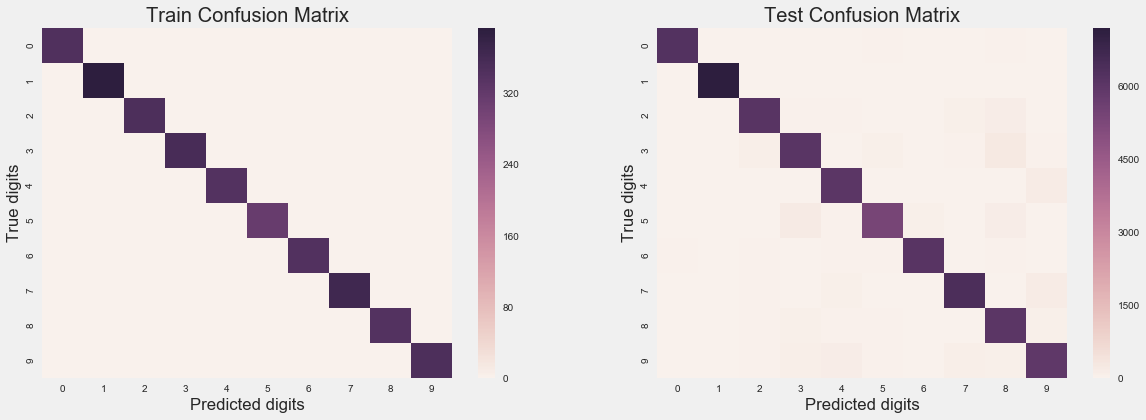

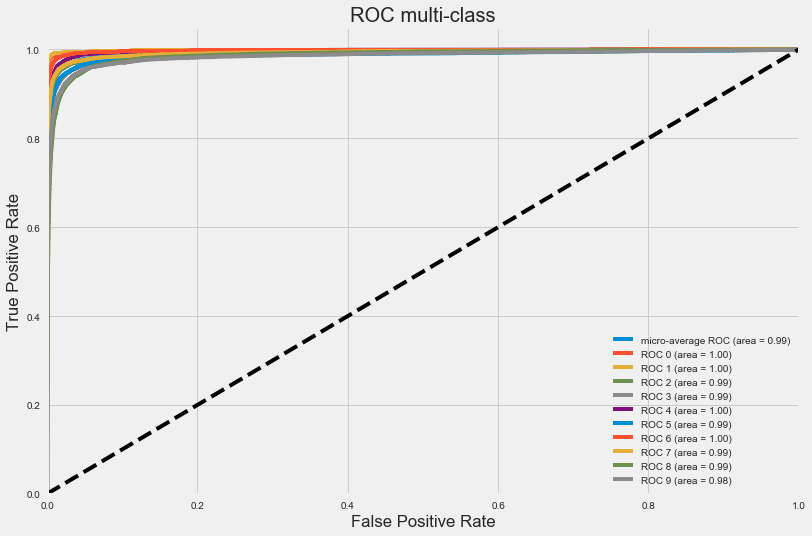

1 loop, best of 1: 24.9 s per loop


In [27]:
%%timeit -n1 -r1
plt.style.use('fivethirtyeight')
pca_polySVC = Pipeline([
                            ('pca',PCA(n_components=26)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

pca_polySVC_y_train_pred, pca_polySVC_y_test_pred = runPipeline(pca_polySVC, 
                                                                X_train, y_train, 
                                                                X_test_large, y_test_large)

In [31]:
from sklearn.manifold import MDS
from sklearn.manifold import SpectralEmbedding

X_mds_train = SpectralEmbedding().fit_transform(X_train)
X_mds_test = SpectralEmbedding().fit_transform(X_test)

In [48]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

### Other Dimensionality Reduction Methods ###

#### Spectral Embedding ####

Spectral embedding didn't add value... quite slow to fit

train set accuracy:  0.279714285714
test set accuracy:  0.273333333333

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       0.94      0.54      0.69       345
        1.0       0.92      0.74      0.82       394
        2.0       0.02      0.01      0.01       349
        3.0       0.14      1.00      0.25       357
        4.0       0.00      0.00      0.00       341
        5.0       0.00      0.00      0.00       316
        6.0       0.00      0.00      0.00       344
        7.0       0.39      0.38      0.39       365
        8.0       0.00      0.00      0.00       341
        9.0       1.00      0.01      0.01       348

avg / total       0.35      0.28      0.23      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.94      0.62      0.75       148
        1.0       0.95      0.69      0.80       169
        2.0       0.00      0.00      0.00       150
        3.

/Users/cooldude/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 loop, best of 1: 1.64 s per loop


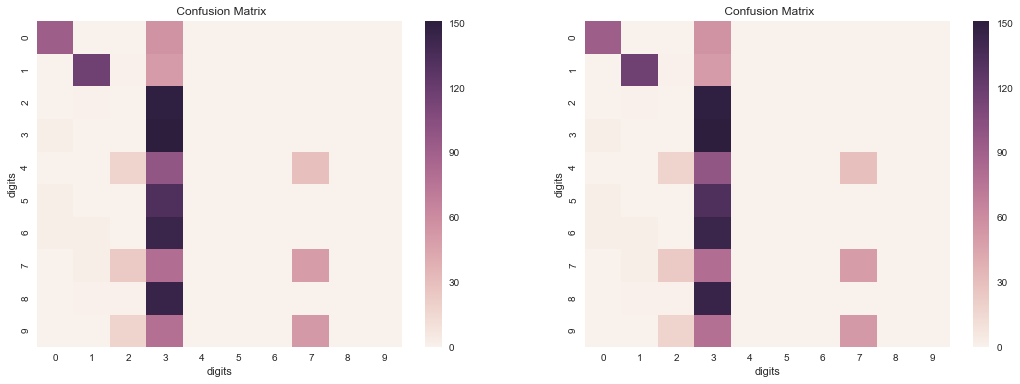

In [33]:
%%timeit -n1 -r1
from sklearn.manifold import mds


sE_polySVC = Pipeline([
                            #('mds', SpectralEmbedding(n_components=2, random_state=4444,
                            #          eigen_solver="arpack")),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

sE_polySVC_y_train_pred, sE_polySVC_y_test_pred = runPipeline(sE_polySVC, 
                                                                X_mds_train, y_train, 
                                                                X_mds_test, y_test)

(3500, 784)

#### MDS Feature Reduction ####

Didn't help at all

train set accuracy:  0.112571428571
test set accuracy:  0.112666666667

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       345
        1.0       0.11      1.00      0.20       394
        2.0       0.00      0.00      0.00       349
        3.0       0.00      0.00      0.00       357
        4.0       0.00      0.00      0.00       341
        5.0       0.00      0.00      0.00       316
        6.0       0.00      0.00      0.00       344
        7.0       0.00      0.00      0.00       365
        8.0       0.00      0.00      0.00       341
        9.0       0.00      0.00      0.00       348

avg / total       0.01      0.11      0.02      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       148
        1.0       0.11      1.00      0.20       169
        2.0       0.00      0.00      0.00       150
        3.

/Users/cooldude/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 loop, best of 1: 58.2 s per loop


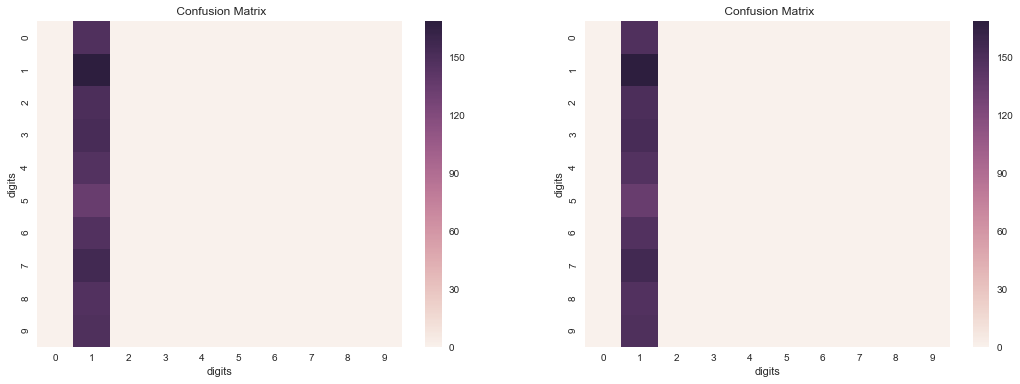

In [47]:
%%timeit -n1 -r1
from sklearn.manifold import mds


LLE_polySVC = Pipeline([
                            ('lle', LocallyLinearEmbedding(#
                                      n_neighbors=100, 
                                      n_components=26,
                                      method='modified',
                                      eigen_solver='dense',
                                      random_state = 4444)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

LLE_polySVC_y_train_pred, LLE_polySVC_y_test_pred = runPipeline(LLE_polySVC, 
                                                                X_train, y_train, 
                                                                X_test, y_test)

#### IsoMap Feature Reduction ####

Not bad... But not as good as PCA. ISOMAP is quite slow

train set accuracy:  1.0
test set accuracy:  0.919292307692

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       345
        1.0       1.00      1.00      1.00       394
        2.0       1.00      1.00      1.00       349
        3.0       1.00      1.00      1.00       357
        4.0       1.00      1.00      1.00       341
        5.0       1.00      1.00      1.00       316
        6.0       1.00      1.00      1.00       344
        7.0       1.00      1.00      1.00       365
        8.0       1.00      1.00      1.00       341
        9.0       1.00      1.00      1.00       348

avg / total       1.00      1.00      1.00      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97      6410
        1.0       0.89      0.99      0.94      7314
        2.0       0.95      0.86      0.91      6491
        3.0       0.9

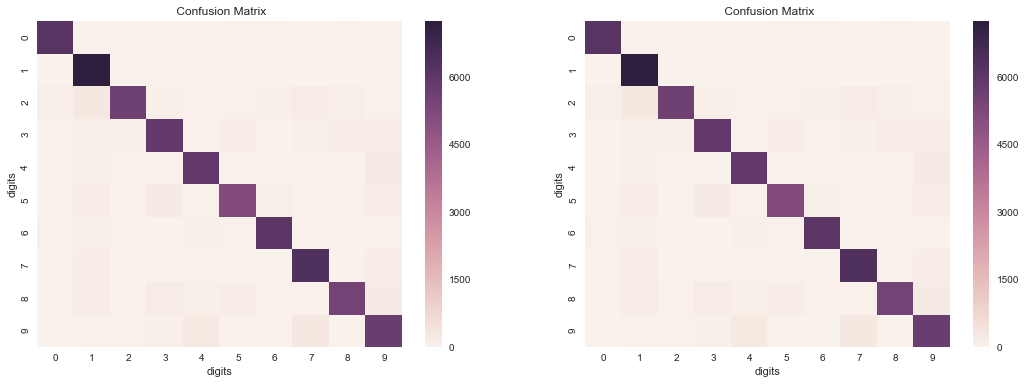

In [51]:
%%timeit -n1 -r1
from sklearn.manifold import mds


iso_polySVC = Pipeline([
                            ('iso', Isomap(#
                                      n_neighbors=100, 
                                      n_components=26)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

iso_polySVC_y_train_pred, iso_polySVC_y_test_pred = runPipeline(iso_polySVC, 
                                                                X_train, y_train, 
                                                                X_test_large, y_test_large)

#### Define image features ####

In [65]:
from skimage.feature import hog
from skimage import exposure

def hogFeatures(X):
    fd = hog(X.reshape(28,28), orientations=2, pixels_per_cell=(5, 5),
                        cells_per_block=(1, 1), visualise=False)
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.03))
    #plt.imshow(hog_image, cmap=plt.cm.gray)
    return(fd)

def tranformToEdges(x):
    edges = feature.canny(x.reshape(28,28), sigma = .5).astype(int).reshape(784)
    return(edges)


In [66]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

class ImageBlurer(TransformerMixin):
#     def __init__(self):
#         self.kpairs = kvpairs
        
    def transform(self, X):
        result = np.apply_along_axis(addHorizontalAndVerticalBlur,1,X)
        return result
    
    def fit(self, *_):
        return self

class HogFeatures(TransformerMixin):
    def transform(self, X):
        result = np.apply_along_axis(hogFeatures,1,X)
        return result
    
    def fit(self, *_):
        return self
    
class Edges(TransformerMixin):
    def transform(self, X):
        result = np.apply_along_axis(tranformToEdges,1,X)
        return result
    
    def fit(self, *_):
        return self

#### HOG Features in addition to PCA ####

Hog features did not add value

/Users/cooldude/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


train set accuracy:  1.0
test set accuracy:  0.946353846154

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       345
        1.0       1.00      1.00      1.00       394
        2.0       1.00      1.00      1.00       349
        3.0       1.00      1.00      1.00       357
        4.0       1.00      1.00      1.00       341
        5.0       1.00      1.00      1.00       316
        6.0       1.00      1.00      1.00       344
        7.0       1.00      1.00      1.00       365
        8.0       1.00      1.00      1.00       341
        9.0       1.00      1.00      1.00       348

avg / total       1.00      1.00      1.00      3500


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98      6410
        1.0       0.98      0.98      0.98      7314
        2.0       0.95      0.94      0.94      6491
        3.0       0.9

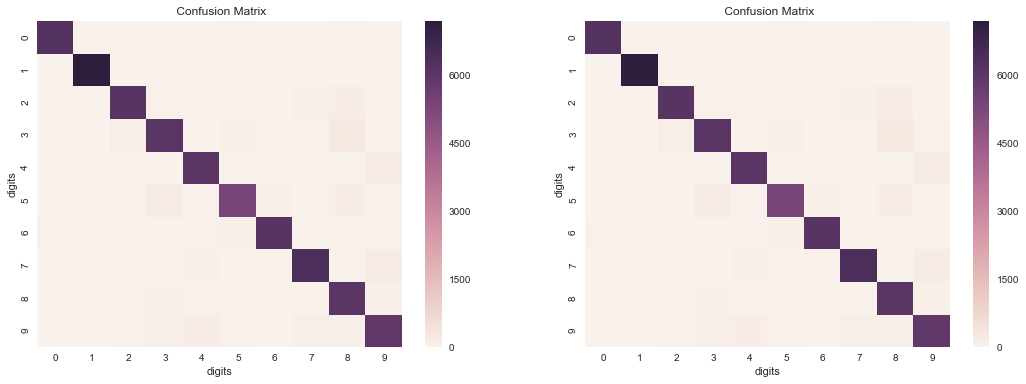

In [58]:
%%timeit -n1 -r1
from sklearn.manifold import mds


hog_polySVC = Pipeline([
                            ('features',FeatureUnion(transformer_list=[('hog', HogFeatures()),
                                    ('pca', PCA(n_components=26))])),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

hog_polySVC_y_train_pred, hog_polySVC_y_test_pred = runPipeline(hog_polySVC, 
                                                                X_train, y_train, 
                                                                X_test_large, y_test_large)

In [39]:
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt

# img = cv2.imread('simple.jpg')
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
# corners = np.int0(corners)

# for i in corners:
#     x,y = i.ravel()
#     cv2.circle(img,(x,y),3,255,-1)

# plt.imshow(img),plt.show()

#### Edge Features ####

Didn't add much value. It seems like edge features are removing information that is neeeded for proper identification of digits in this problem

In [ ]:
%%timeit -n1 -r1
from sklearn.manifold import mds


edges_pca_polySVC = Pipeline([
                            ('edges', Edges()),#
                            ('pca', PCA(n_components=26)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

edges_pca_polySVC_y_train_pred, edges_pca_polySVC_y_test_pred = runPipeline(edges_pca_polySVC, 
                                                                X_train, y_train, 
                                                                X_test_large, y_test_large)

#### Learning Curve ####

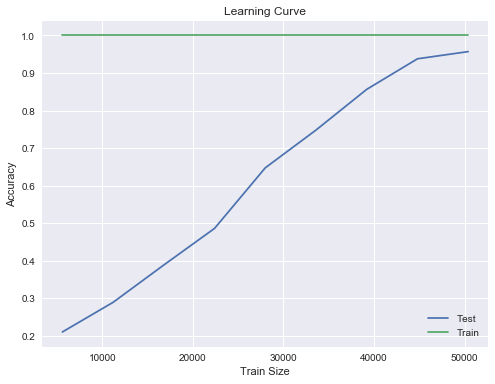

In [25]:

pca_polySVC = Pipeline([
                            ('pca',PCA(n_components=26)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])
train_sizes, train_scores, test_scores = learning_curve(pca_polySVC, X,y, train_sizes=np.arange(10,99,10)/100, groups=y, cv=5, n_jobs=-1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_sizes,np.apply_along_axis(np.mean, 1, test_scores), label='Test')
ax.plot(train_sizes,np.apply_along_axis(np.mean, 1, train_scores), label='Train')
ax.set_title('Learning Curve')
ax.set_xlabel('Train Size')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
fig.set_size_inches(8,6)

In [21]:
np.apply_along_axis(np.mean,1,test_scores)

array([ 0.2106571 ,  0.28960867])

### Final Model ###

Best model:
Perform PCA using 26 components on features, then feed those components to a Support Vector Classifier that uses a Polynomial kernel. Use a regularization constant C=1.

train set accuracy:  1.0
test set accuracy:  0.976238095238

Classification Report: Train set
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4832
        1.0       1.00      1.00      1.00      5514
        2.0       1.00      1.00      1.00      4893
        3.0       1.00      1.00      1.00      4999
        4.0       1.00      1.00      1.00      4777
        5.0       1.00      1.00      1.00      4419
        6.0       1.00      1.00      1.00      4813
        7.0       1.00      1.00      1.00      5105
        8.0       1.00      1.00      1.00      4777
        9.0       1.00      1.00      1.00      4871

avg / total       1.00      1.00      1.00     49000


Classification Report: Test set
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      2071
        1.0       0.99      0.99      0.99      2363
        2.0       0.96      0.98      0.97      2097
        3.0       0.9

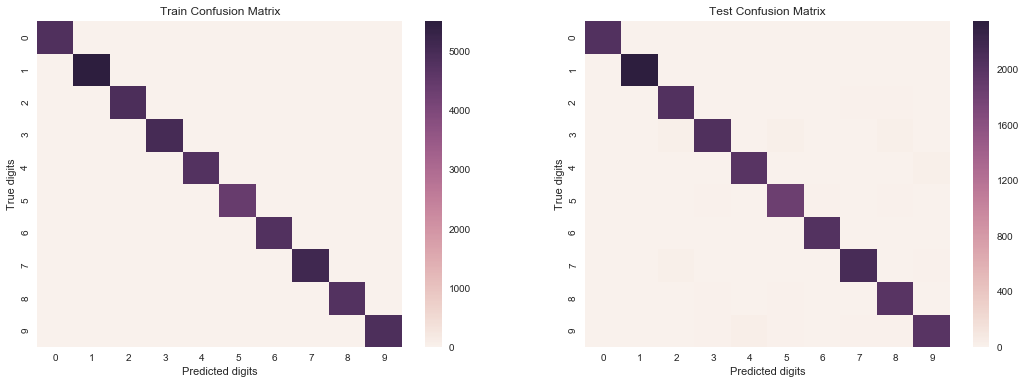

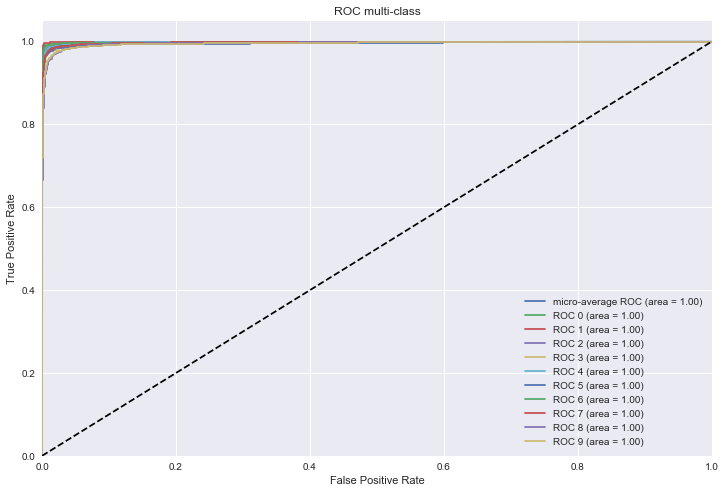

In [12]:
X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 4444, stratify= y)

pca_polySVC_full = Pipeline([
                            ('pca',PCA(n_components=26)),
                            ('polySvc', svm.SVC(C=1,
                                              kernel='poly',

                                              probability = True,
                                              random_state=42)
                            )
                         ])

pca_polySVC_full_y_train_pred, pca_polySVC_full_y_test_pred = runPipeline(pca_polySVC_full, 
                                                                                  X_train, y_train, 
                                                                                  X_test, y_test)

### Save Model ###

In [ ]:
from sklearn.externals import joblib
joblib.dump(pca_polySVC_full, '../FlaskApp/model.full.pkl') 